<a href="https://colab.research.google.com/github/HeshamAbdallah02/Bimaristan/blob/master/AI_Doctor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install iterative-stratification scikit-learn imbalanced-learn xgboost

# **Import libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler, OrdinalEncoder,
    MultiLabelBinarizer, FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
import joblib
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Custom XGBoost classifier

In [ ]:
class DynamicXGBClassifier(XGBClassifier):
    def fit(self, X, y, **kwargs):
        if self.objective == 'multi:softprob':
            self.set_params(num_class=len(np.unique(y)))
        return super().fit(X, y, **kwargs)

# **1. Load and prepare the data**

In [ ]:
df = pd.read_csv('disease_diagnosis.csv')

# **2. Preprocess the data**

Function to process blood pressure

In [ ]:
def process_blood_pressure(bp_string):
    try:
        systolic, diastolic = map(int, bp_string.split('/'))
        return systolic, diastolic
    except:
        return np.nan, np.nan

def combine_symptoms(row):
    return [str(symptom) for symptom in row[['Symptom_1', 'Symptom_2', 'Symptom_3']]
            if pd.notnull(symptom)]

df['Systolic'], df['Diastolic'] = zip(*df['Blood_Pressure_mmHg'].apply(process_blood_pressure))
df['Symptoms'] = df.apply(combine_symptoms, axis=1)

Feature engineering: clinical indicators

In [ ]:
df['Has_Fever'] = (df['Body_Temperature_C'] >= 38).astype(int)
df['Tachycardia'] = (df['Heart_Rate_bpm'] > 100).astype(int)
df['Hypertension_Stage'] = pd.cut(df['Systolic'],
                                 bins=[0, 120, 130, 140, 180],
                                 labels=['Normal', 'Elevated', 'Stage1', 'Stage2'])

#**3. Define preprocessing pipeline**

In [ ]:
class SafeMultiLabelBinarizer(MultiLabelBinarizer):
    def fit_transform(self, X, y=None):
        return super().fit_transform(X)

    def transform(self, X, y=None):
        return super().transform(X)

symptom_transformer = Pipeline([
    ('extractor', FunctionTransformer(lambda x: np.array(x.tolist()), validate=False)),
    ('encoder', SafeMultiLabelBinarizer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'Heart_Rate_bpm', 'Body_Temperature_C',
                                  'Oxygen_Saturation_%', 'Systolic', 'Diastolic']),
        ('symp', symptom_transformer, 'Symptoms'),
        ('clin', OneHotEncoder(handle_unknown='ignore'), ['Gender', 'Hypertension_Stage']),
        ('ind', 'passthrough', ['Has_Fever', 'Tachycardia'])
    ],
    remainder='drop'
)

# **4. Define multi-output model with class weights**


In [ ]:
from sklearn.multioutput import MultiOutputClassifier as _MOC

class SafeMultiOutputClassifier(_MOC):
    def predict(self, X):
        """
        For each underlying estimator:
          - call its predict(X)
          - if it returns a 2D array, collapse via argmax → 1D labels
          - otherwise keep it as-is
        Then stack all 1D arrays column-wise.
        """
        cols = []
        for est in self.estimators_:
            p = est.predict(X)
            # if you got back something like (n_samples, n_classes), pick the highest-prob class
            if hasattr(p, 'ndim') and p.ndim > 1:
                p = np.argmax(p, axis=1)
            cols.append(p)
        # now each p is (n_samples,) — stack into (n_samples, n_outputs)
        return np.stack(cols, axis=1)


In [ ]:
base_model = DynamicXGBClassifier(
    objective='multi:softprob',
    tree_method='hist',
    use_label_encoder=False
)

model = SafeMultiOutputClassifier(
    Pipeline([
       ('preprocessor', preprocessor),
       ('imputer',     KNNImputer(n_neighbors=5)),
       ('classifier',  DynamicXGBClassifier(
                          objective='multi:softprob',
                          tree_method='hist',
                          use_label_encoder=False
                       ))
    ]),
    n_jobs=-1
)

# **5. Prepare targets & features**

In [ ]:
X = df[['Age', 'Gender', 'Symptoms', 'Heart_Rate_bpm', 'Body_Temperature_C',
        'Oxygen_Saturation_%', 'Systolic', 'Diastolic', 'Has_Fever',
        'Tachycardia', 'Hypertension_Stage']]

diagnosis_encoder = OneHotEncoder(sparse_output=False)
severity_encoder = OrdinalEncoder(categories=[['Mild', 'Moderate', 'Severe']])
treatment_encoder = OneHotEncoder(sparse_output=False)

y = np.hstack([
    diagnosis_encoder.fit_transform(df[['Diagnosis']]),
    severity_encoder.fit_transform(df[['Severity']]),
    treatment_encoder.fit_transform(df[['Treatment_Plan']])
])


# **6. Train-test split**

In [ ]:
# First split: hold-out vs “the rest”
X_rest, X_holdout, y_rest, y_holdout = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Then split X_rest into your train/test for CV/tuning
X_train, X_test, y_train, y_test = train_test_split(
    X_rest, y_rest, test_size=0.20, random_state=42, stratify=y_rest
)

In [ ]:
# --- DEBUG CELL: which estimator is throwing the inhomogeneous‐shape error? ---

# Fit your multi‐output model on the training split
model.fit(X_train, y_train)
print("✔️ model.fit completed without error.")

# Try each sub‐estimator’s predict in isolation
for idx, est in enumerate(model.estimators_):
    try:
        preds = est.predict(X_test)
        print(f"Estimator #{idx:>2} predict OK: shape = {preds.shape}, dtype = {preds.dtype}")
    except Exception as e:
        print(f"⚠️ Estimator #{idx:>2} predict FAILED:", e)

# Finally, test the combined predict
try:
    all_preds = model.predict(X_test)
    print("Combined predict OK:", all_preds.shape)
except Exception as e:
    print("Combined model.predict FAILED:", e)


✔️ model.fit completed without error.
Estimator # 0 predict OK: shape = (340, 2), dtype = float64
Estimator # 1 predict OK: shape = (340, 2), dtype = float64
Estimator # 2 predict OK: shape = (340, 2), dtype = float64
Estimator # 3 predict OK: shape = (340, 2), dtype = float64
Estimator # 4 predict OK: shape = (340, 2), dtype = float64
Estimator # 5 predict OK: shape = (340,), dtype = int64
Estimator # 6 predict OK: shape = (340, 2), dtype = float64
Estimator # 7 predict OK: shape = (340, 2), dtype = float64
Estimator # 8 predict OK: shape = (340, 2), dtype = float64
Combined predict OK: (340, 9)


# **7. Custom scoring function**

In [ ]:
def multi_output_macro_f1(y_true, y_pred):
    """
    Compute per-output macro-F1 and average them,
    but treat any nan F1 as 0.0 so the overall score stays numeric.
    """
    scores = []
    for i in range(y_true.shape[1]):
        score_i = f1_score(
            y_true[:, i],
            y_pred[:, i],
            average='macro',
            zero_division=0
        )
        # convert any nan result into 0.0
        if np.isnan(score_i):
            score_i = 0.0
        scores.append(score_i)
    return float(np.mean(scores))

In [ ]:
# Quick sanity check: this should print a finite float (e.g. 1.0 if you pass perfect data)
print("Sanity test (should be a number, not nan):",
      multi_output_macro_f1(y_train[:20], y_train[:20]))

Sanity test (should be a number, not nan): 1.0


In [ ]:
from sklearn.model_selection import cross_val_score

# 1. Reuse the same CV splitter and scorer
cv = MultilabelStratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_scorer = make_scorer(multi_output_macro_f1)

# 2. Evaluate your base model without any grid search
baseline_scores = cross_val_score(
    model,           # your MultiOutputClassifier pipeline
    X_train,         # training inputs
    y_train,         # training labels
    cv=cv,
    scoring=f1_scorer,
    n_jobs=-1
)

print(f"Baseline 3-fold CV macro-F1: {baseline_scores.mean():.4f} ± {baseline_scores.std():.4f}")


Baseline 3-fold CV macro-F1: 0.9987 ± 0.0018


# **8. Hyperparameter tuning**

In [ ]:
param_grid = {
    'estimator__classifier__max_depth': [4, 6],
    'estimator__classifier__learning_rate': [0.05, 0.1],
    'estimator__classifier__n_estimators': [200, 300]
}

# 1. Wrap your multi-output F1 in a proper scorer
f1_scorer = make_scorer(multi_output_macro_f1)

# 2. Create a shuffled, reproducible stratified splitter
cv = MultilabelStratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 3. Plug into GridSearchCV
grid_search = GridSearchCV(
    estimator   = model,        # your MultiOutputClassifier pipeline
    param_grid  = param_grid,   # same dict you already defined
    cv          = cv,
    scoring     = f1_scorer,
    verbose     = 3,
    error_score = 'raise',
    n_jobs      = -1
)


In [ ]:
outer_cv = MultilabelStratifiedKFold(
    n_splits=5, shuffle=True, random_state=0
)

nested_scores = cross_val_score(
    grid_search,       # your entire GridSearchCV pipeline
    X_rest, y_rest,    # the “rest” (not the hold-out)
    cv=outer_cv,
    scoring=make_scorer(multi_output_macro_f1),
    n_jobs=-1
)

print("Nested CV F1: %.4f ± %.4f"
      % (nested_scores.mean(), nested_scores.std()))

Nested CV F1: 1.0000 ± 0.0000


# **9. Training**


In [ ]:
grid_search.fit(X_train, y_train)

print("Mean test scores per setting:")
print(grid_search.cv_results_['mean_test_score'])

print("Best params:", grid_search.best_params_)
print("Best CV macro-F1:", grid_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Mean test scores per setting:
[0.99902732 0.99886171 0.99869671 0.9985305  0.99886171 0.99886171
 0.9985305  0.9985305 ]
Best params: {'estimator__classifier__learning_rate': 0.05, 'estimator__classifier__max_depth': 4, 'estimator__classifier__n_estimators': 200}
Best CV macro-F1: 0.9990273167706358


# **10. Evaluation**

In [ ]:
# Retrieve best model
best_model = grid_search.best_estimator_

# Predict on test set using SafeMultiOutputClassifier
y_pred = best_model.predict(X_test)

# Define output slice sizes
n_diag  = diagnosis_encoder.categories_[0].shape[0]
n_sev   = 1
n_treat = treatment_encoder.categories_[0].shape[0]

# Print classification reports
print("=== Diagnosis ===")
print(classification_report(
    y_test[:, :n_diag],
    y_pred[:, :n_diag],
    target_names=diagnosis_encoder.categories_[0],
    zero_division=0
))

print("=== Severity ===")
print(classification_report(
    y_test[:, n_diag:n_diag+n_sev].ravel(),
    y_pred[:, n_diag:n_diag+n_sev].ravel(),
    target_names=severity_encoder.categories_[0].tolist(),
    zero_division=0
))

print("=== Treatment Plan ===")
print(classification_report(
    y_test[:, -n_treat:],
    y_pred[:, -n_treat:],
    target_names=treatment_encoder.categories_[0],
    zero_division=0
))

# Overall multi-output macro-F1
print(f"Overall multi-output macro-F1: {multi_output_macro_f1(y_test, y_pred):.4f}")


# **12. Function to make predictions for new patients**

def predict_patient(record: dict):
    """
    record should contain keys:
      'Age', 'Gender', 'Symptoms', 'Heart_Rate_bpm',
      'Body_Temperature_C', 'Oxygen_Saturation_%',
      'Blood_Pressure_mmHg' (e.g. "120/80")
    Returns a dict with Diagnosis, Severity, Treatment_Plan.
    """
    dfp = pd.DataFrame([record])
    dfp[['Systolic','Diastolic']] = dfp['Blood_Pressure_mmHg'].apply(
        lambda s: pd.Series(process_blood_pressure(s))
    )
    dfp['Has_Fever']    = (dfp['Body_Temperature_C'] >= 38).astype(int)
    dfp['Tachycardia']  = (dfp['Heart_Rate_bpm'] > 100).astype(int)
    dfp['Hypertension_Stage'] = pd.cut(
        dfp['Systolic'],
        bins=[0,120,130,140,180],
        labels=['Normal','Elevated','Stage1','Stage2']
    )
    dfp['Symptoms'] = dfp['Symptoms']
    Xp = dfp[['Age','Gender','Symptoms','Heart_Rate_bpm',
              'Body_Temperature_C','Oxygen_Saturation_%',
              'Systolic','Diastolic','Has_Fever','Tachycardia',
              'Hypertension_Stage']]
    y_p = best_model.predict(Xp)
    diag_pred = diagnosis_encoder.inverse_transform(y_p[:, :n_diag])
    sev_pred  = severity_encoder.inverse_transform(y_p[:, n_diag:n_diag+n_sev])
    treat_pred= treatment_encoder.inverse_transform(y_p[:, -n_treat:])
    return {
        'Diagnosis': diag_pred[0] if len(diag_pred[0])>1 else diag_pred[0][0],
        'Severity': sev_pred[0][0],
        'Treatment_Plan': list(treat_pred[0])
    }


# **Example usage:**

new_patient = {
    'Age': 52,
    'Gender': 'Female',
    'Symptoms': ['Cough','Fatigue'],
    'Heart_Rate_bpm': 88,
    'Body_Temperature_C': 38.5,
    'Oxygen_Saturation_%': 94,
    'Blood_Pressure_mmHg': '135/85'
}

result = predict_patient(new_patient)
print("Predicted diagnosis:", result['Diagnosis'])
print("Predicted severity:", result['Severity'])
print("Recommended treatment plan:", result['Treatment_Plan'])


=== Diagnosis ===
              precision    recall  f1-score   support

  Bronchitis       1.00      1.00      1.00        57
        Cold       1.00      1.00      1.00        28
         Flu       1.00      1.00      1.00        50
     Healthy       1.00      1.00      1.00       198
   Pneumonia       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00       340
   macro avg       1.00      1.00      1.00       340
weighted avg       1.00      1.00      1.00       340
 samples avg       1.00      1.00      1.00       340

=== Severity ===
              precision    recall  f1-score   support

        Mild       1.00      1.00      1.00       226
    Moderate       1.00      1.00      1.00        50
      Severe       1.00      1.00      1.00        64

    accuracy                           1.00       340
   macro avg       1.00      1.00      1.00       340
weighted avg       1.00      1.00      1.00       340

=== Treatment Plan ===
                  

In [ ]:
def perturb(X, sigma=0.01):
    Xp = X.copy()
    # Add Gaussian noise: 1% stddev
    for col in ['Body_Temperature_C','Heart_Rate_bpm','Systolic','Diastolic']:
        Xp[col] += np.random.normal(0, sigma * Xp[col].mean(), size=Xp.shape[0])
    return Xp

Xjitter = perturb(pd.DataFrame(X_test, columns=X.columns))
yj_pred = best_model.predict(Xjitter)
print("Jittered F1:", multi_output_macro_f1(y_test, yj_pred))


Jittered F1: 0.9404861990317956


In [ ]:
!pip install shap
import shap

<Figure size 640x480 with 0 Axes>

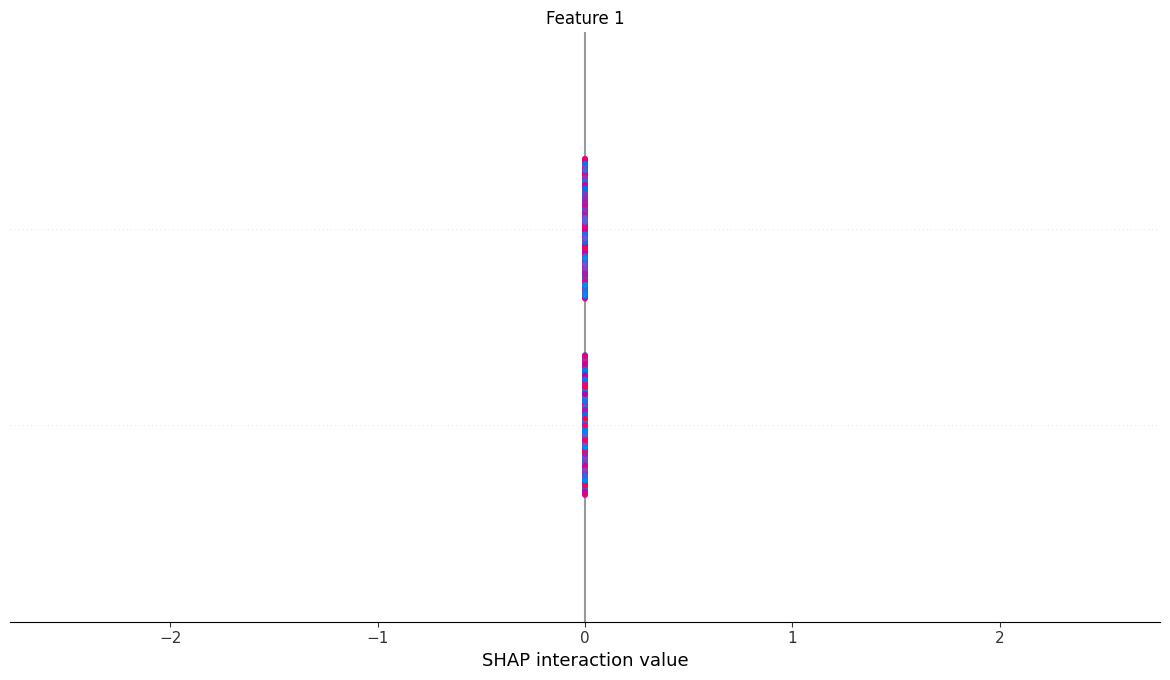

In [ ]:
single_model = best_model.estimators_[0]
xgb_model = single_model.named_steps['classifier']
X_test_transformed = single_model.named_steps['preprocessor'].transform(X_test)

try:
    feature_names = single_model.named_steps['preprocessor'].get_feature_names_out()
except:
    feature_names = [f'Feature {i}' for i in range(X_test_transformed.shape[1])]

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="dot")

In [ ]:
# Evaluate your final model on the true hold-out set:
yh_pred = best_model.predict(X_holdout)
print("Hold-out F1:",
      multi_output_macro_f1(y_holdout, yh_pred))

Hold-out F1: 0.9934253234427809


# **11. Function to make predictions for new patients**


# **Example usage:**
